In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

import requests
import zipfile
import imageio
import os

import umap
import MulticoreTSNE
import fitsne
import LargeVis
import sklearn.manifold

### Pull the data from the internet and write it to a file

In [2]:
%%time
if not os.path.isfile('coil20.zip'):
    results = requests.get('http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-20/coil-20-proc.zip')
    with open("coil20.zip", "wb") as code:
        code.write(results.content)

CPU times: user 36 µs, sys: 30 µs, total: 66 µs
Wall time: 74.1 µs


### Read in from file and transform into a vector space

We add a filter to ensure that we only parse png files from our download zip.

In [3]:
import re
images_zip = zipfile.ZipFile('coil20.zip')
mylist = images_zip.namelist()
r = re.compile(".*\.png$")
filelist = list(filter(r.match, mylist))

Next we pull the object id's from the file names using pandas

In [4]:
if not os.path.isfile('coil-20-proc/obj10__1.png'):
    !unzip coil20.zip

In [5]:
%%time
feature_vectors = []
for filename in filelist:
    im = imageio.imread(filename)
    feature_vectors.append(im.flatten())

CPU times: user 904 ms, sys: 213 ms, total: 1.12 s
Wall time: 1.35 s


### Now we have our data in a list of vectors.  Let's extract the object id's from the files and cast to data frame (in case we want to explore things further)

We could leave this data in numpy arrays for improved efficiency but at data sizes this small the added functionality of pandas for potential exploration is appealing.

In [6]:
labels = pd.Series(filelist).str.extract("obj([0-9]+)", expand=False)

In [7]:
data = pd.DataFrame(feature_vectors, index=labels)
data.shape

(1440, 16384)

### Now let's use UMAP to embed these points into a two dimensional space.

In [8]:
fit = umap.UMAP(n_neighbors=5, n_epochs=2000, random_state=42, min_dist=0.5)
%time u = fit.fit_transform(data)

/Users/leland/anaconda3/envs/umap_dev/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/Users/leland/anaconda3/envs/umap_dev/lib/python3.5/site-packages/umap_learn-0.3.2-py3.5.egg/umap/spectral.py:229: UserWarning: Embedding 12 connected components using meta-embedding (experimental)
/Users/leland/anaconda3/envs/umap_dev/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


CPU times: user 9.93 s, sys: 251 ms, total: 10.2 s
Wall time: 9.42 s


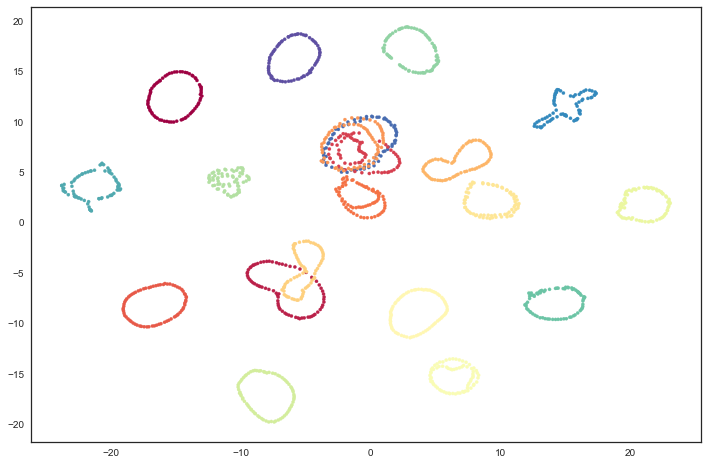

In [9]:
plt.scatter(u[:,0], u[:,1], c=labels, cmap="Spectral", s=10)

We see here that UMAP manages to preserve much of the loop structure that is inherent within the coil data set. The coil data set was constructed by taking 20 objects and photographing them at various rotations.  These rotations are being reveiled by the locality preserving property of UMAP.

TO DO: Look at the global structure in between the groups

In [10]:
output = pd.DataFrame(u, columns=('x','y'))
output['labels']=labels
output.to_csv('embedding_coil20_umap1.csv')

### T-SNE

In [11]:
fit_tsne = MulticoreTSNE.MulticoreTSNE(n_jobs=1, random_state=42)
%time u_tsne = fit_tsne.fit_transform(data)

CPU times: user 18 s, sys: 127 ms, total: 18.2 s
Wall time: 18.2 s


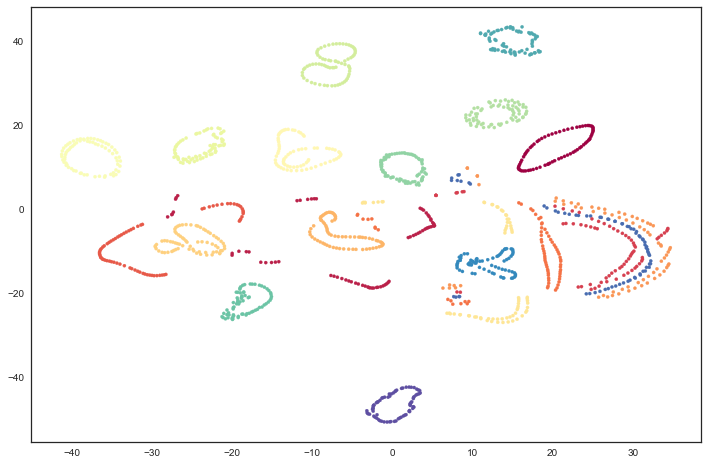

In [12]:
plt.scatter(u_tsne[:,0], u_tsne[:,1], c=labels, cmap="Spectral", s=10)

t-SNE breaks more of the loops losing some of the loop structure inherent in COIL.  On the other hand it does a very good job of seperating the objects within COIL.

TO DO: Examine the global positioning of COIL objects.

In [13]:
output = pd.DataFrame(u_tsne, columns=('x','y'))
output['labels']=labels
output.to_csv('embedding_coil20_tsne1.csv')

In [14]:
sklearn.manifold.t_sne.trustworthiness(data.values, u_tsne, n_neighbors=15)

0.99311060796152539

In [15]:
sklearn.manifold.t_sne.trustworthiness(data.values, u, n_neighbors=15)

0.9895159962361797

## MDS

For old times sake we attempt to embed with multi-dimensional scaling

In [16]:
fit_mds = sklearn.manifold.MDS(random_state=42)
%time u_mds = fit_mds.fit_transform(data)

CPU times: user 1min 40s, sys: 13.3 s, total: 1min 54s
Wall time: 57.9 s


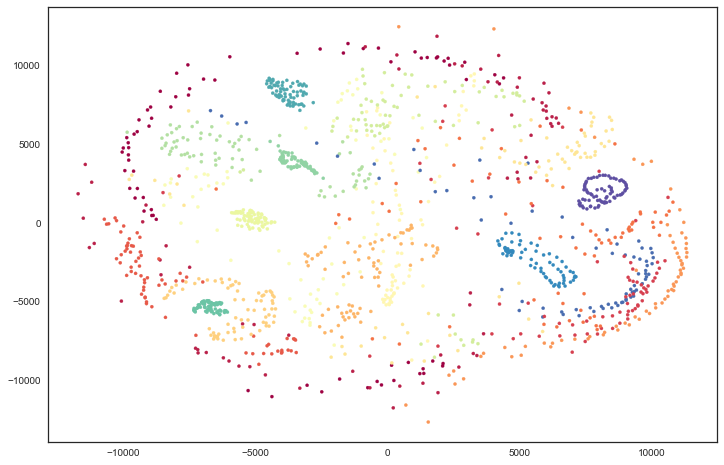

In [17]:
plt.scatter(u_mds[:,0], u_mds[:,1], c=labels, cmap="Spectral", s=10)

MDS and PCA (below) should do a better job preserving global structure at the expense of sacrificying local structure.  These can be seen in the loss of loop structure in our data and the dispersal of points across our space.

### PCA

The old standby of PCA which is blindingly fast to compute and often used as an initialization to many of the more complex algorithms.  This isn't really a competitor but instead should be thought of as a strawman.  Given that other algorithms initialize with these values one would hope that they can do better.

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
%time u_pca = pca.fit_transform(data)

CPU times: user 1.49 s, sys: 249 ms, total: 1.74 s
Wall time: 952 ms


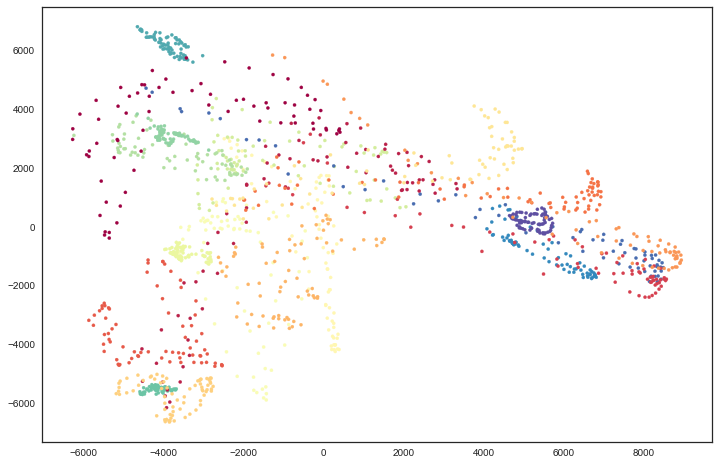

In [19]:
plt.scatter(u_pca[:,0], u_pca[:,1], c=labels, cmap="Spectral", s=10)

### ISOMAP 

Isomap should be to reveal some of the non-linear structure in our manifold where PCA and MDS had difficulties.

In [20]:
fit_isomap = sklearn.manifold.Isomap(n_neighbors=5)
%time u_isomap = fit_isomap.fit_transform(data)

CPU times: user 38.6 s, sys: 346 ms, total: 38.9 s
Wall time: 39.1 s


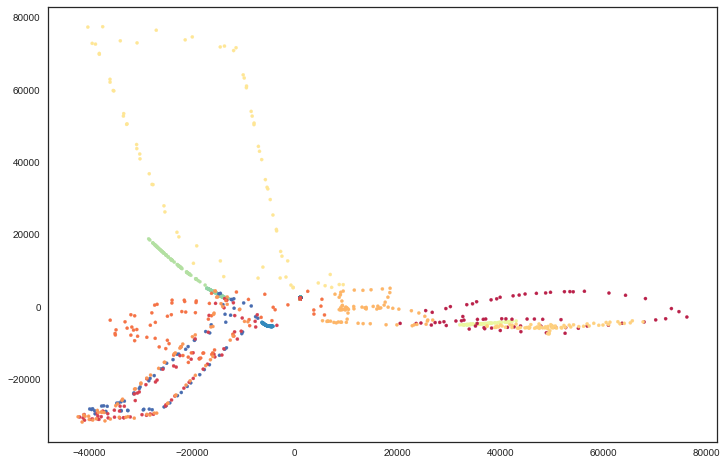

In [21]:
plt.scatter(u_isomap[:,0], u_isomap[:,1], c=labels, cmap="Spectral", s=10)

Isomap was able to identify some of the loop structure with COIL but is unable to separate the objects cleanly.  

## FIt-SNE

In [22]:
%time u_fitsne = fitsne.FItSNE(data.values.astype(np.double, order='C'), nthreads=1, rand_seed=42)

CPU times: user 1min 12s, sys: 3.39 s, total: 1min 15s
Wall time: 1min 15s


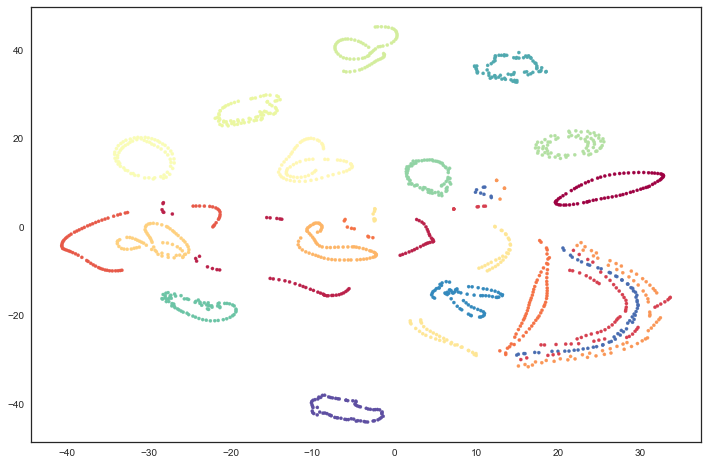

In [23]:
plt.scatter(u_fitsne[:,0], u_fitsne[:,1], c=labels, cmap="Spectral", s=10)

In [24]:
np.save('fitsne_coil20_embedding1.npy', u_fitsne)

In [25]:
output = pd.DataFrame(u_fitsne, columns=('x','y'))
output['labels']=labels
output.to_csv('embedding_coil20_fitsne1.csv')

## LargeVis

In [27]:
largevis_data = data.values.astype(np.float32, order='C')
LargeVis.loadarray(largevis_data)

In [28]:
%time u_largevis = LargeVis.run(2, 1)

CPU times: user 15min 57s, sys: 8.4 s, total: 16min 6s
Wall time: 16min 10s


In [29]:
u_largevis = np.array(u_largevis)

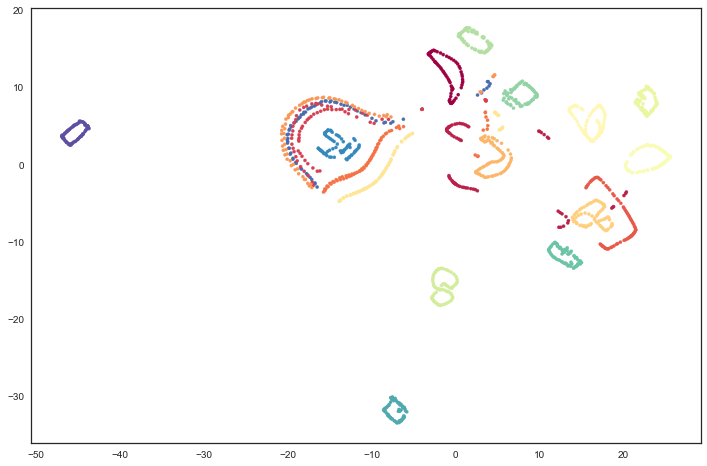

In [30]:
plt.scatter(u_largevis[:,0], u_largevis[:,1], c=labels, cmap="Spectral", s=10)

In [31]:
np.save('largevis_coil20_embedding1.npy', u_largevis)

In [32]:
output = pd.DataFrame(u_largevis, columns=('x','y'))
output['labels']=labels
output.to_csv('embedding_coil20_largevis1.csv')